In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve1d,gaussian_filter1d

import itertools

plt.style.use('ggplot')

   

In [2]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 15ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [3]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))






#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [37]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.09] = 0.0
    else:
        if r_bpc < 0.09:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.0025] = 0.0
    return np.maximum(q_pc,0)

# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    
    ee_kernel  = np.maximum((ee_kernel- gaba_exc ),0.001)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))  * 1/(gaba_exc +1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = np.maximum((ei_kernel- gaba_inh ),0.001)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) * 1/(gaba_inh +1.0) 
    
            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc



In [38]:



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

## Stimuli  Influence on LSP Response

In [51]:

# GABA parameter
gaba_inh = np.linspace(0,1.6,5)

# to simulate that the gaba influence on the inhibitory side is stronger
gaba_exc = gaba_inh * 1.0

# GABA parameter
# gaba_exc = np.array([2,6,10,14,16,18,20,22])
# gaba_inh = np.arange(0,18.5,5.0)

# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))



sbc_input_intensities = np.array([1.0])
gbc_input_intensities = np.array([1.0])


# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))


# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(gaba_exc)):
    
    l = k 
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 2.0

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 200
    gbc_input_duration = 500
    gbc_center_frequencyBand =3
    gbc_input_strength = 2.0
   
    # build ramps
    time_window = 200
    for i in range(0,len(t)-time_window,time_window):
        s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = i/(len(t)) * gbc_input_strength
        
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

    
    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 200
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 2.0
    
    # build ramps
    time_window = 200
    for i in range(0,len(t)-time_window,time_window):
        s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = (len(t)-i)/(len(t)) * sbc_input_strength

     # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi

    s_sbc_all *= sbc_input_intensities[0]
    s_gbc_all *= gbc_input_intensities[0]

    for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc[l],gaba_inh[k])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc[l],gaba_inh[k])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)





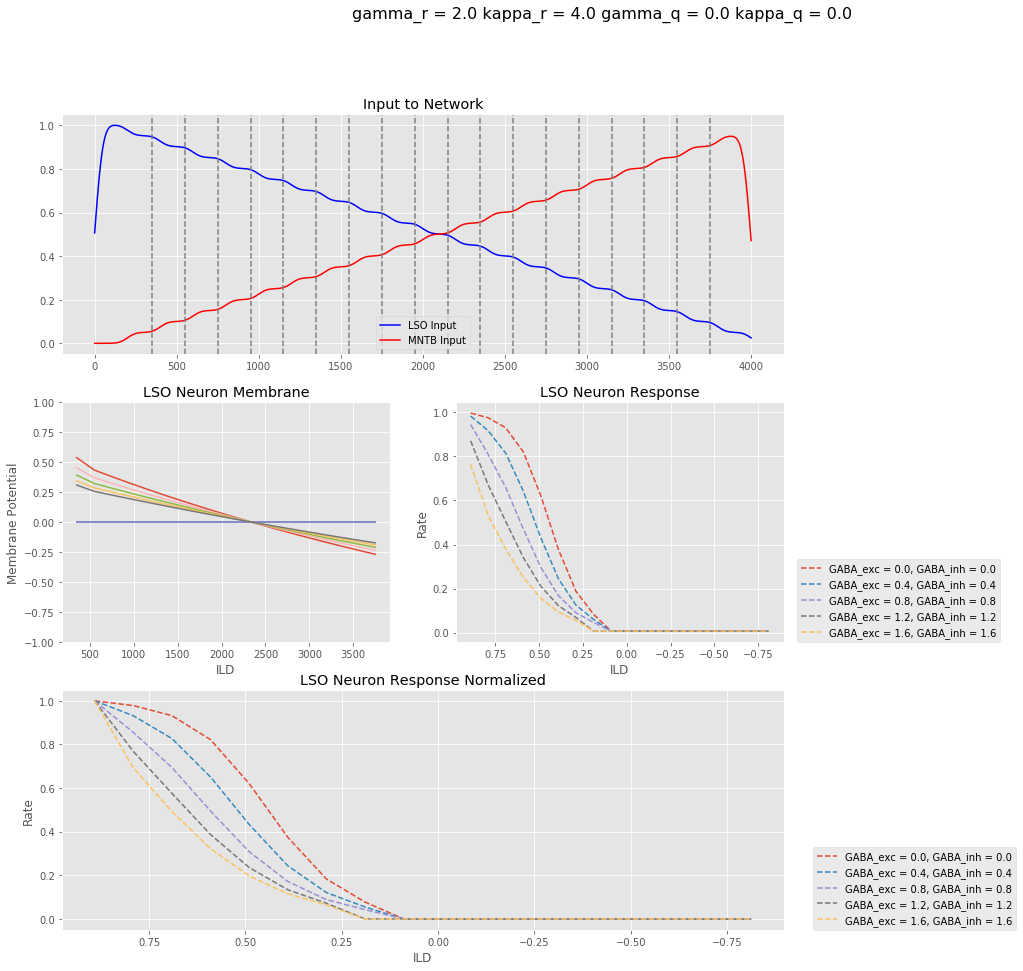

In [52]:
# Define the times when to probe
probing_times = [300,700,1100,1500,1900,2300,2700,3100,3500]
probing_times = np.arange(350,len(t)-time_window,time_window)


fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    for j in range(0,r.shape[1]):
        plt.plot(probing_times,r[i,j,probing_times])
plt.title('LSO Neuron Membrane')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])

## show LSO neuron response
ax2 = plt.subplot2grid((3, 3), (1, 1), colspan=1)
for i in range(0,r.shape[0]):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
#     tmp = tmp -  np.min(tmp)
#     tmp = tmp / np.max(tmp)
    ax2.plot(diff_input[probing_times],tmp,linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
# plt.ylim([0,1])
plt.legend(loc=(1.04,0))

## show LSO neuron response normalized
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
for i in range(0,r.shape[0]):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
    tmp = tmp -  np.min(tmp)
    tmp = tmp / np.max(tmp)
    ax2.plot(diff_input[probing_times],tmp,linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response Normalized')
plt.xlabel('ILD')
plt.ylabel('Rate')
# plt.ylim([0,1])
plt.legend(loc=(1.04,0))

plt.show()


